### Exercitiul 1

Preziceţi consumul unei maşini (în mile/galon: mpg) pe baza cailor putere (CP). Fişierul auto-mpg.csv
conţine un set de date cu observaţii, din care ne interesează doar cele corespunzătoare cailor putere şi valorile
mpg corespunzătoare.

a) Încărcaţi setul de date într-un Pandas DataFrame şi trasaţi un grafic (după eventuala curăţare a datelor)
pentru a vizualiza relaţia de dependenţă dintre cele două variabile: CP şi mpg.

b) Definiţi modelul în PyMC folosind CP ca variabilă independentă şi mpg ca variabilă dependentă.

c) Determinaţi care este dreapta de regresie care se potriveşte cel mai bine datelor.

d) Adăugaţi graficului de la punctul a) regiunea 95% HDI pentru distribuţia predictivă a posteriori. Ce
concluzie puteţi trage asupra modelului?

In [ ]:
%pip install pandas
%pip install pymc
%pip install matplotlib
%pip install arviz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


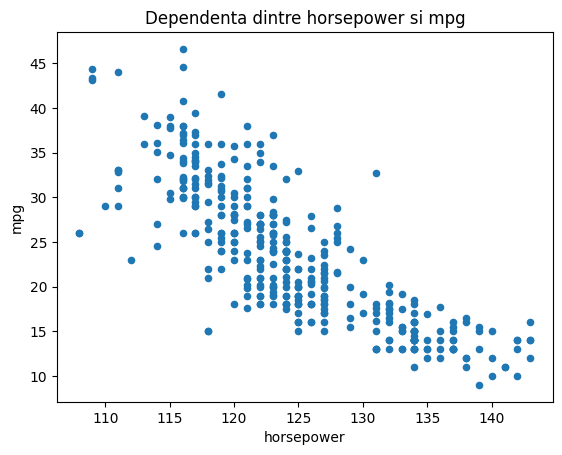

In [ ]:
#a - dependenta dintre horsepower si mpg
from matplotlib import pyplot as plt
import pandas as pd 
import pymc as pm
import arviz as az

allData = pd.read_csv("C:/Users/teodo/Desktop/PMP-2024/Lab09 (10)/Tema pentru lab9/auto-mpg.csv")
allData['horsepower'] = pd.to_numeric(allData['horsepower'], errors='coerce')
allData['mpg'] = pd.to_numeric(allData['mpg'], errors='coerce')
data= allData[['horsepower', 'mpg']]
data= allData.dropna()

horsepower= data['horsepower']
mpg= data['mpg']

#print(horsepower)
#print(mpg)

df=pd.DataFrame({'horsepower': horsepower, 'mpg': mpg})
df.plot(kind='scatter', x='horsepower', y='mpg')
plt.title('Dependenta dintre horsepower si mpg')
plt.savefig('dependenta.png')
#plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


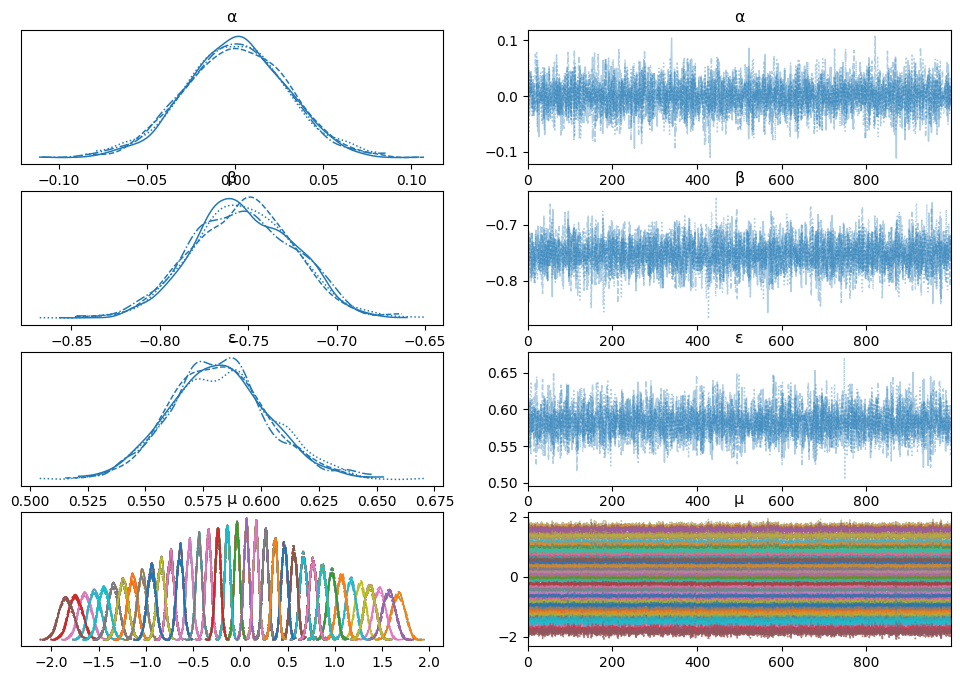

In [26]:
#b - definirea modelului
horsepower = (horsepower - horsepower.mean()) / horsepower.std()
mpg = (mpg - mpg.mean()) / mpg.std()

with pm.Model() as model_g:
    α = pm.Normal('α', mu=0,sigma=1)  
    β = pm.Normal('β', mu=0,sigma=0.1)   
    ε = pm.HalfNormal('ε', sigma=1)
       

    μ = pm.Deterministic('μ', α + β * horsepower)
    y_obs = pm.Normal('y_obs', mu=μ, sigma=ε, observed=mpg)
    trace = pm.sample(1000, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace)
plt.savefig('trace.png')

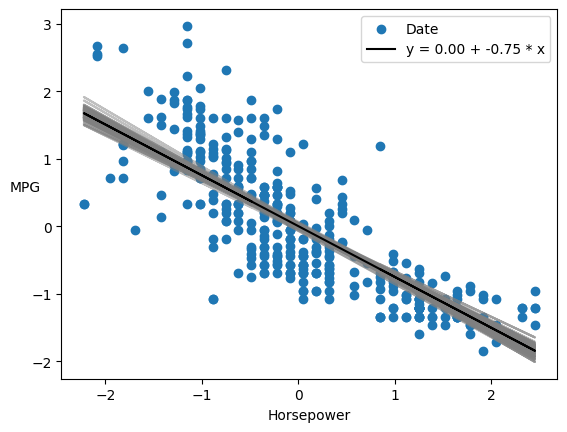

In [27]:
#c - dreapta de regresie
idata_g = trace
posterior_g = idata_g.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()

plt.figure() 
plt.scatter(horsepower, mpg, label="Date", c='C0')

draws = range(0, 100)
for i in draws:
    plt.plot(horsepower, posterior_g['α'][i].values + posterior_g['β'][i].values * horsepower, 
             c='gray', alpha=0.5)

plt.plot(horsepower, alpha_m + beta_m * horsepower, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('Horsepower')
plt.ylabel('MPG', rotation=0)
plt.legend()

plt.savefig('regression_lines.png')
plt.show()

Sampling: [y_obs]


Output()

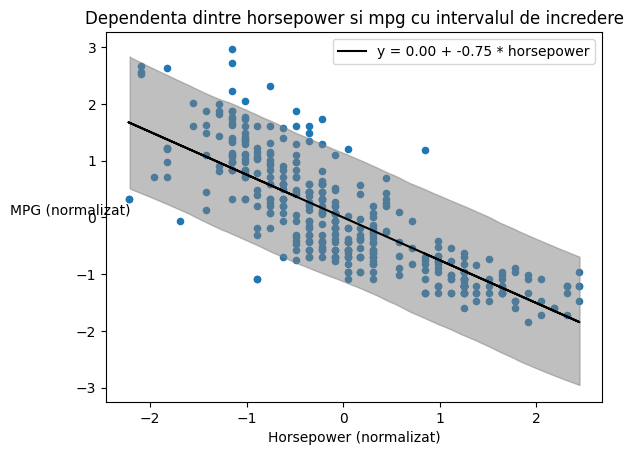

In [28]:
#d plot a cu interval de incredere pentru distributia predictiva 
ppc_norm = pm.sample_posterior_predictive(trace, model_g)

df = pd.DataFrame({'horsepower': horsepower, 'mpg': mpg})
ax = df.plot(kind='scatter', x='horsepower', y='mpg')

ax.plot(horsepower, alpha_m + beta_m * horsepower, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * horsepower')

az.plot_hdi(horsepower, ppc_norm['posterior_predictive']['y_obs'], hdi_prob=0.95, color='gray',  ax=ax)

ax.set_xlabel('Horsepower (normalizat)')
ax.set_ylabel('MPG (normalizat)', rotation=0)
ax.legend()
ax.set_title("Dependenta dintre horsepower si mpg cu intervalul de incredere")

plt.savefig('ppc_hdi_normalized_scale.png')
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


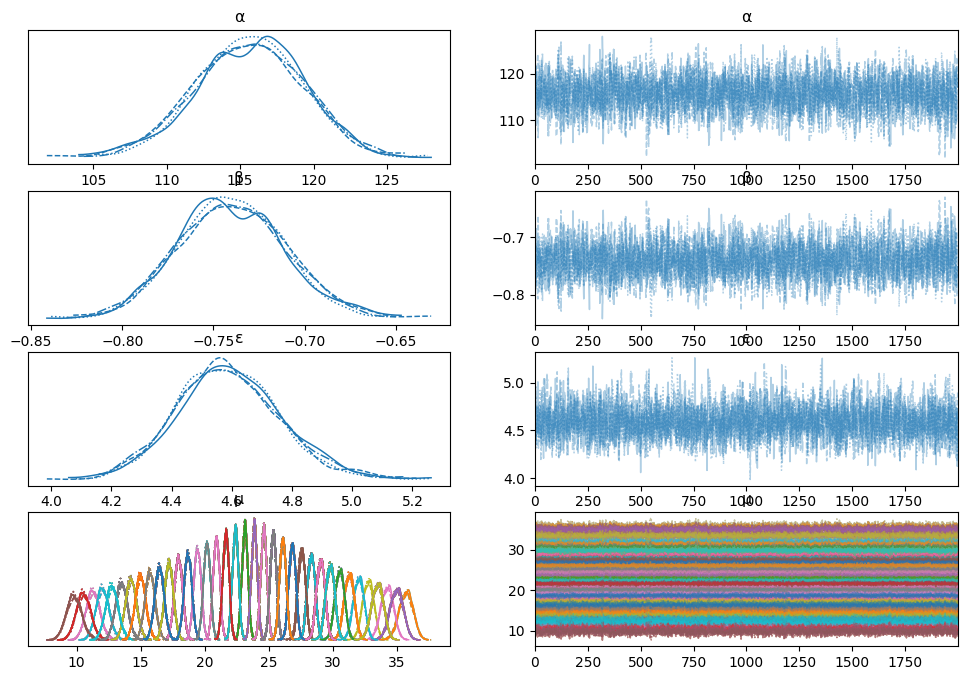

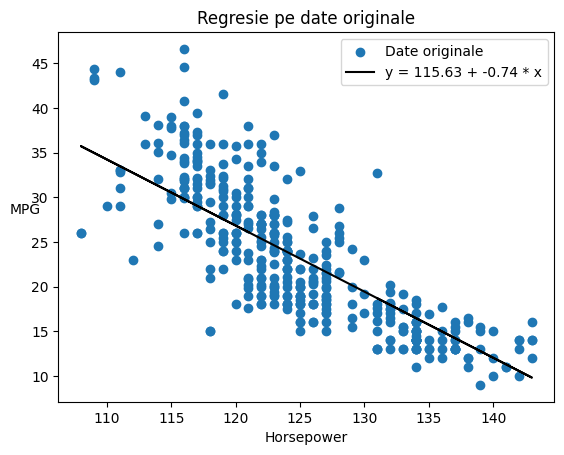

Sampling: [y_obs]


Output()

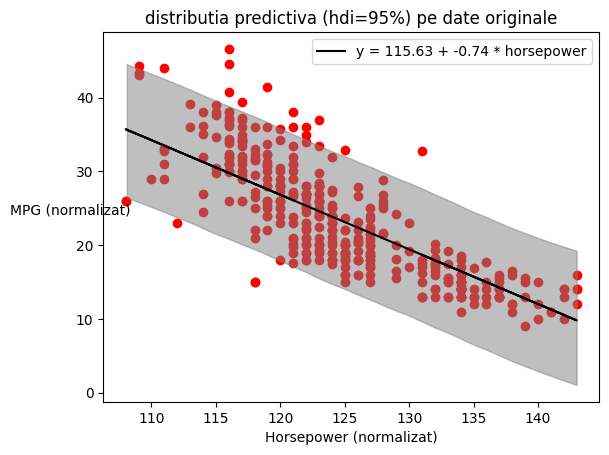

In [ ]:
#problema fara standardizare
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import pandas as pd

allData = pd.read_csv("C:/Users/teodo/Desktop/PMP-2024/Lab09 (10)/Tema pentru lab9/auto-mpg.csv")
allData['horsepower'] = pd.to_numeric(allData['horsepower'], errors='coerce')
allData['mpg'] = pd.to_numeric(allData['mpg'], errors='coerce')
data = allData[['horsepower', 'mpg']].dropna()

horsepower = data['horsepower']
mpg = data['mpg']

with pm.Model() as model_g:
    α = pm.Normal('α', mu=mpg.mean(), sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', sigma=5)

    μ = pm.Deterministic('μ', α + β * horsepower)
    y_obs = pm.Normal('y_obs', mu=μ, sigma=ε, observed=mpg)

    trace = pm.sample(2000, return_inferencedata=True)

az.plot_trace(trace)
az.summary(trace)
plt.savefig('trace_original_scale.png')

posterior = trace.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior['α'].mean().item()
beta_m = posterior['β'].mean().item()

plt.figure()
plt.scatter(horsepower, mpg, label="Date originale", color='C0')

plt.plot(horsepower, alpha_m + beta_m * horsepower, color='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('Horsepower')
plt.ylabel('MPG', rotation=0)
plt.legend()
plt.title("Regresie pe date originale")
plt.savefig('regression_original_scale.png')
plt.show()

ppc = pm.sample_posterior_predictive(trace,  model=model_g)

plt.figure()
plt.scatter(horsepower, mpg, color='r')
plt.plot(horsepower, alpha_m + beta_m * horsepower, c='k', 
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * horsepower')

az.plot_hdi(horsepower, ppc['posterior_predictive']['y_obs'], hdi_prob=0.95, color='gray')

plt.xlabel('Horsepower (normalizat)')
plt.ylabel('MPG (normalizat)', rotation=0)
plt.legend()
plt.title("distributia predictiva (hdi=95%) pe date originale")
plt.savefig('ppc_hdi.png')
plt.show()


In [ ]:
print(data[['horsepower', 'mpg']].corr())


            horsepower       mpg
horsepower    1.000000 -0.817717
mpg          -0.817717  1.000000


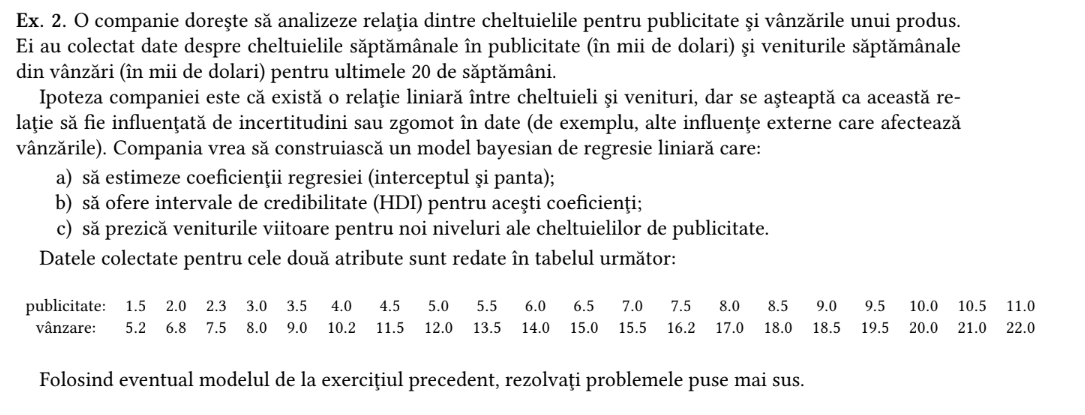

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Interval HDI pentru α : <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    α        (hdi) float64 16B 2.546 3.244
Interval HDI pentru β: <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    β        (hdi) float64 16B 1.683 1.782


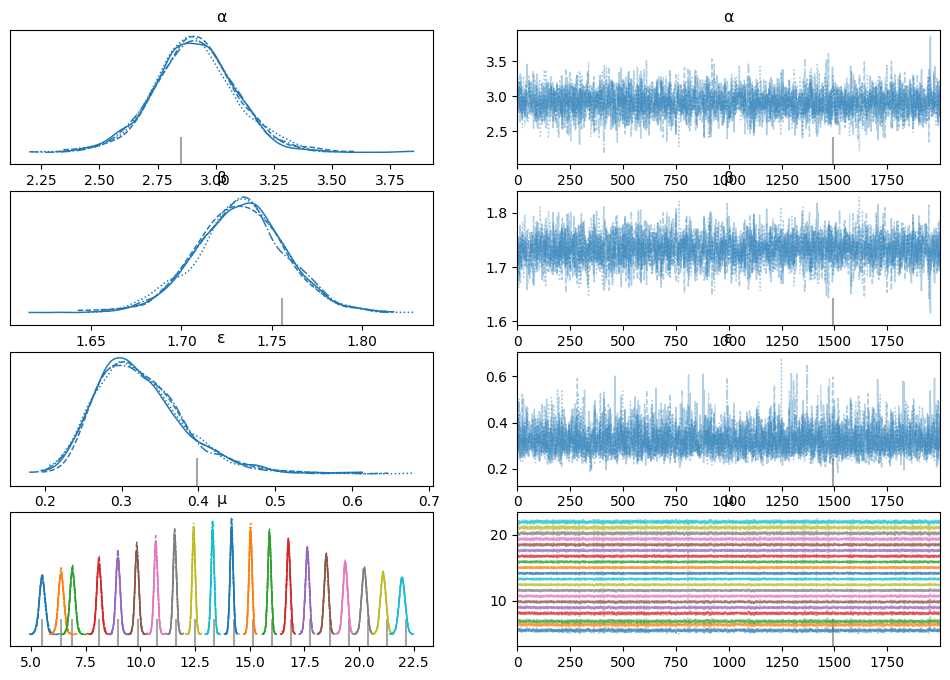

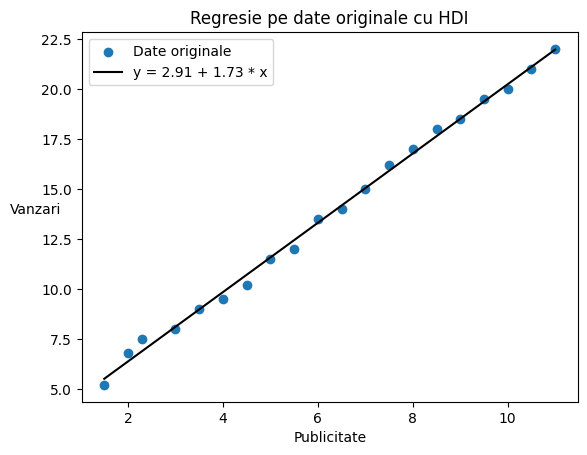

In [ ]:
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import pandas as pd

publicitate = [1.5, 2.0, 2.3, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 
               6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11]
vanzari = [5.2, 6.8, 7.5, 8.0, 9.0, 9.5, 10.2, 11.5, 12.0, 13.5, 
           14.0, 15, 16.2, 17.0, 18.0, 18.5, 19.5, 20.0, 21.0, 22.0]

data = pd.DataFrame({'publicitate': publicitate, 'vanzari': vanzari})

with pm.Model() as model_g:
    α = pm.Normal('α', mu=data['vanzari'].mean(), sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', sigma=5)

    μ = pm.Deterministic('μ', α + β * data['publicitate'])
    y_obs = pm.Normal('y_obs', mu=μ, sigma=ε, observed=data['vanzari'])
    trace = pm.sample(2000, return_inferencedata=True)

summary = az.summary(trace, hdi_prob=0.95)
#print(summary)

hdi_alpha = az.hdi(trace.posterior['α'], hdi_prob=0.95)
hdi_beta = az.hdi(trace.posterior['β'], hdi_prob=0.95)

print("Interval HDI pentru α :", hdi_alpha)
print("Interval HDI pentru β:", hdi_beta)

az.plot_trace(trace)
plt.show()

posterior = trace.posterior.stack(samples={"chain", "draw"})
alpha_m = posterior['α'].mean().item()
beta_m = posterior['β'].mean().item()

plt.figure()
plt.scatter(data['publicitate'], data['vanzari'], label="Date originale", color='C0')
plt.plot(data['publicitate'], alpha_m + beta_m * data['publicitate'], color='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('Publicitate')
plt.ylabel('Vanzari', rotation=0)
plt.legend()
plt.title("Regresie pe date originale cu HDI")
plt.show()


Interval HDI pentru α: [2.54560218 3.24411487]
Interval HDI pentru β: [1.68294264 1.78237808]


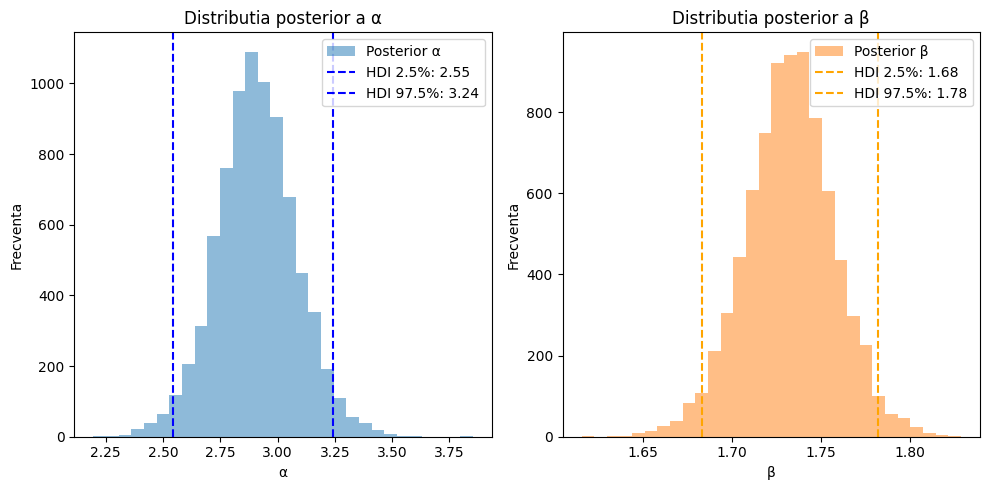

In [24]:
#b - intervale de incredere 
print("Interval HDI pentru α:", hdi_alpha)
print("Interval HDI pentru β:", hdi_beta)


hdi_alpha = az.hdi(trace, var_names=['α'], hdi_prob=0.95)['α'].values
hdi_beta = az.hdi(trace, var_names=['β'], hdi_prob=0.95)['β'].values

alpha_samples = trace.posterior['α'].values.flatten()
beta_samples = trace.posterior['β'].values.flatten()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(alpha_samples, bins=30, color='C0', alpha=0.5, label='Posterior α')
plt.axvline(hdi_alpha[0], color='blue', linestyle='--', label=f"HDI 2.5%: {hdi_alpha[0]:.2f}")
plt.axvline(hdi_alpha[1], color='blue', linestyle='--', label=f"HDI 97.5%: {hdi_alpha[1]:.2f}")
plt.title("Distributia posterior a α")
plt.xlabel('α')
plt.ylabel('Frecventa')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(beta_samples, bins=30, color='C1', alpha=0.5, label='Posterior β')
plt.axvline(hdi_beta[0], color='orange', linestyle='--', label=f"HDI 2.5%: {hdi_beta[0]:.2f}")
plt.axvline(hdi_beta[1], color='orange', linestyle='--', label=f"HDI 97.5%: {hdi_beta[1]:.2f}")
plt.title("Distributia posterior a β")
plt.xlabel('β')
plt.ylabel('Frecventa')
plt.legend()

plt.tight_layout()
plt.show()


Sampling: []


Output()

<xarray.DataArray 'μ' (draw: 2000, μ_dim_2: 20)> Size: 320kB
array([[ 5.53051628,  6.39006902,  6.90580066, ..., 20.14291275,
        21.00246548, 21.86201822],
       [ 5.5352599 ,  6.40033338,  6.91937747, ..., 20.24150908,
        21.10658257, 21.97165605],
       [ 5.45937663,  6.32838195,  6.84978515, ..., 20.23246708,
        21.1014724 , 21.97047772],
       ...,
       [ 5.48694641,  6.36203277,  6.88708458, ..., 20.36341452,
        21.23850088, 22.11358724],
       [ 5.4784844 ,  6.3477687 ,  6.86933928, ..., 20.25631754,
        21.12560184, 21.99488614],
       [ 5.49320111,  6.35784891,  6.87663758, ..., 20.1922136 ,
        21.0568614 , 21.92150919]])
Coordinates:
  * draw     (draw) int32 8kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * μ_dim_2  (μ_dim_2) int32 80B 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19


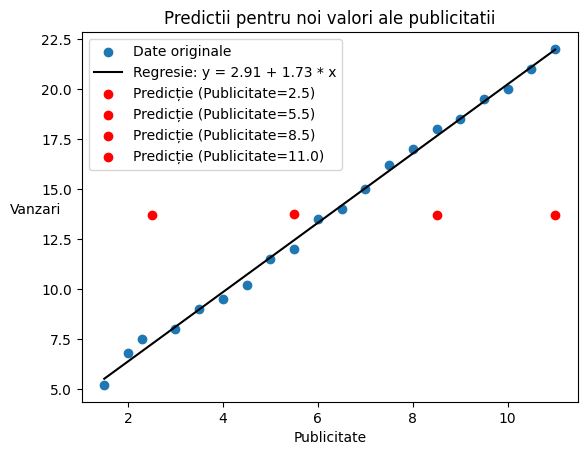

In [ ]:
#c - predictii pentru noi valori ale publicitatii 
# putem folosi dreapta de regresie sau modelul de la prima problema pentru a prezice vanzarile pentru noi valori ale publicitatii

publicitate_noua = [2.5, 5.5, 8.5, 11.0]

with model_g:
    predictive = pm.sample_posterior_predictive(trace, var_names=["μ"])

#predictive.values
mu_predictions = predictive['posterior_predictive']["μ"]

pred_mean = mu_predictions.mean(axis=0)
print(pred_mean)
#pred_hdi = az.hdi(mu_predictions, hdi_prob=0.95)
#print(pred_hdi)

plt.figure()
plt.scatter(data['publicitate'], data['vanzari'], label="Date originale", color='C0')
plt.plot(data['publicitate'], alpha_m + beta_m * data['publicitate'], color='k', label=f'Regresie: y = {alpha_m:.2f} + {beta_m:.2f} * x')

for i, p in enumerate(publicitate_noua):
    pred_mean_value = mu_predictions[:, i].mean() #media pt fiecare rand pentru esantioane 
    plt.scatter(p, pred_mean_value, color='red', label=f"Predicție (Publicitate={p})")


plt.xlabel('Publicitate')
plt.ylabel('Vanzari', rotation=0)
plt.legend()
plt.title("Predictii pentru noi valori ale publicitatii")
plt.show()
